# Benchmarking

## Description

This notebook compares the quality of algorithms in `Roerich`, `Ruptures` and `klcpd` libraries.

We use “WISDM Smartphone and Smartwatch Activity and Biometrics Dataset” [1, 2], prepared by the Wireless Sensor Data Mining (WISDM) Lab in the Department of Computer and Information Science of Fordham University. The dataset includes data from the accelerometer and gyroscope sensors of a smartphone and smartwatch collected as 51 subjects performed 18 diverse activities of daily living.  Each activity was performed for 3 minutes, so that each subject contributed 54 minutes of data. These activities include basic ambulation-related activities (e.g., walking, jogging, climbing stairs), hand-based activities of daily living (e.g., brushing teeth, folding clothes), and various eating activities (eating pasta, easting chips).

Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. The data collection was controlled by a custom-made app that ran on the smartphone and smartwatch. The sensor data was collected at a rate of 20 Hz (i.e., every 50ms) from the accelerometer and gyroscope on both the smartphone and smartwatch, yielding four total sensors.

- [1] Weiss, Gary. (2019). WISDM Smartphone and Smartwatch Activity and Biometrics Dataset . UCI Machine Learning Repository. [[link]](https://archive-beta.ics.uci.edu/ml/datasets/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset)

- [2] Weiss, Gary & Yoneda, Kenichi & Hayajneh, Thaier. (2019). Smartphone and Smartwatch-Based Biometrics Using Activities of Daily Living. IEEE Access. PP. 1-1. [[DOI]](http://dx.doi.org/10.1109/ACCESS.2019.2940729).


## Data Download

The dataset is stored in UCI Machine Learning Repository and available for download via this [link](https://archive-beta.ics.uci.edu/ml/datasets/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset).

In [1]:
#!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
#!unzip -o -q wisdm-dataset.zip

In this example, we use data from a smartwatch accelerometer collected from one subject. The data file contains the following columns:

- **id:** uniquely identifies the subject. Rand: 1600 - 1650;
- **activity:** identifies a specific activity. Range: A-S (no “N” value);
- **timestamp:** Linux time;
- **x:** sensor value for x axis. May be positive or negative;
- **y:** same as x but for y axis;
- **z:** same as x but for z axis;

Let’s download the dataset and read a sample.

In [2]:
#!pip install -q roerich

In [3]:
#import of basic libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import roerich
import torch

In [4]:
# helping function for reading the data
def remove_char(fname):
    with open(fname, "r") as f:
        flist = f.readlines()
        flist = [s.replace(';', '') for s in flist]
    with open(fname[:-4] + '_debug.txt', "w") as f:
        f.writelines(flist)

In [5]:
# path to a file in the dataset
data_path = "wisdm-dataset/raw/watch/accel/data_1600_accel_watch.txt"

remove_char(data_path)

In [6]:
# read the data
cols = ["id", "activity", "timestamp", "x", "y", "z"]
data = pd.read_csv(data_path[:-4] + '_debug.txt', names=cols)
data.head()

,id,activity,timestamp,x,y,z
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.696732
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027


## Preprocessing

We will use only sensor measurements and activity labels. So, let’s define the input matrix X and the label vector y. We will take every 20'th observation in order to speed up the computation.


In [7]:
#Taking only every 20th observation
X = data[['x', 'y', 'z']].values[::20]
y = data['activity'].values[::20]

However, we do not need the activity labels by itself, but moments of the activity changes. We consider them as change points of the signal, and our goal is to detect them.


In [8]:
# transform activity labels into change point positions
def get_true_cpds(y):
    cps_true = []
    for i in range(1, len(y)):
        if y[i] != y[i-1]:
            cps_true.append(i)
    return np.array(cps_true)

In [9]:
# get true change point positions
cps_true = get_true_cpds(y)

Then, we preprocess the time series using `StandardScaler`. It is not mandatory in general case, but sometimes can be useful :). Besides this, we add some noise to our signal. This hack is a regularization technique that helps to reduce sensitivity of the change point detection methods. It decreases the number of change points within one activity.


In [10]:
from sklearn.preprocessing import StandardScaler

# scale the signal
ss = StandardScaler().fit(X)
X_ss = ss.transform(X)

# add noise for regularization
X_ss += np.random.normal(0, 0.1, X_ss.shape)

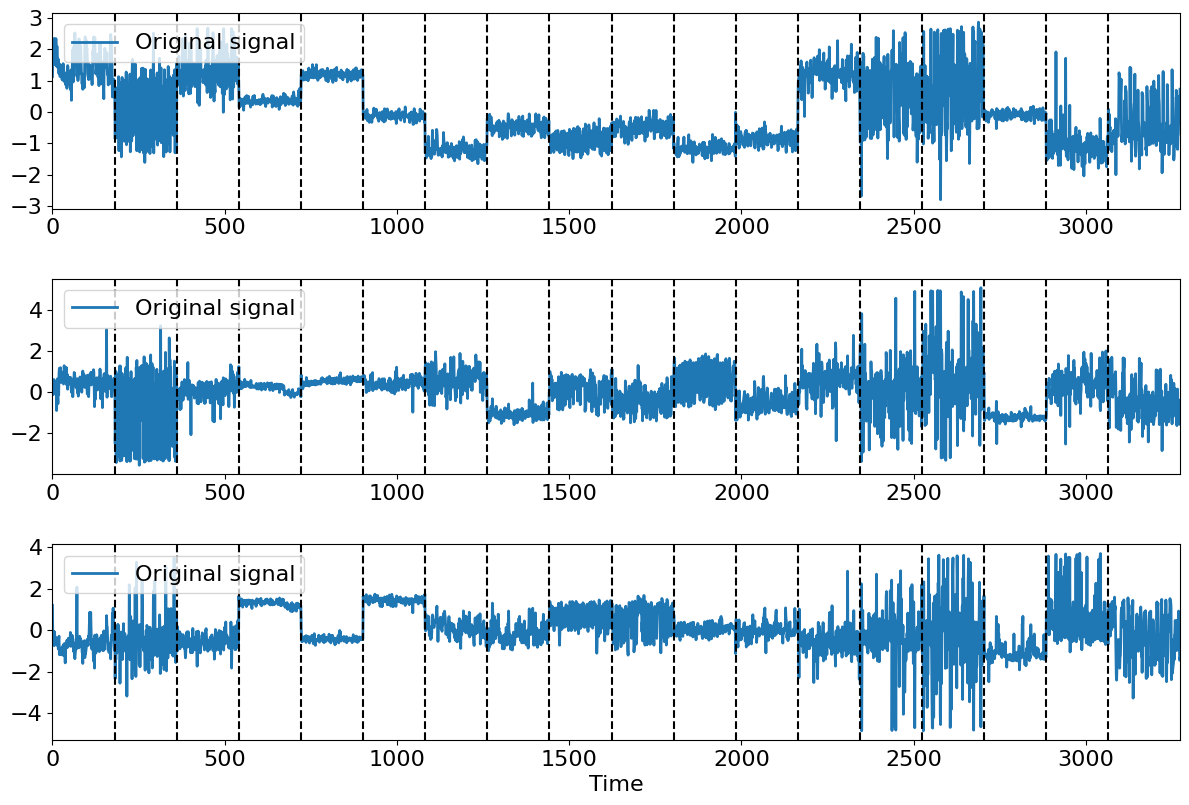

In [11]:
roerich.display(X_ss, cps_true)

## Comparison of algorithms

In this section we will compare algorithms from the `Roerich` library with a few from other libraries ([`Ruptures`](https://centre-borelli.github.io/ruptures-docs/) and [`klcpd`](https://github.com/HolyBayes/klcpd))

### `Roerich`

In [12]:
#Default parameters (taken from `Usage` tab in documentation)

base_clf = 'mlp'
base_reg = 'mlp'

base_window_size = 50
base_lag_size = 50

base_periods = 1
base_n_runs = 1
base_step = 1
base_n_epochs = 10
base_n_splits = 5

base_alpha = 0.2
base_lr = 0.01
base_lam = 0.0001
base_optimizer = 'Adam'

In [13]:
from roerich.change_point import ChangePointDetectionRuLSIF, ChangePointDetectionClassifier, \
                               EnergyDistanceCalculator, ChangePointDetectionClassifierCV, \
                               OnlineNNRuLSIF, OnlineNNClassifier, SlidingWindows


algorithms = [(ChangePointDetectionClassifier(base_classifier=base_clf, metric='KL_sym',
                                              periods=base_periods, window_size=base_window_size,
                                              step=base_step, n_runs=base_n_runs), 'ChangePointDetectionClassifier'),

              (ChangePointDetectionClassifierCV(base_classifier=base_clf, metric='KL_sym',
                                                periods=base_periods, window_size=base_window_size,
                                                step=base_step, n_splits=base_n_splits), 'ChangePointDetectionClassifierCV'),

              (ChangePointDetectionRuLSIF(base_regressor=base_reg, metric='PE',
                                          periods=base_periods, window_size=base_window_size,
                                          step=base_step, n_runs=base_n_runs), 'ChangePointDetectionRuLSIF'),

              (OnlineNNRuLSIF(alpha=base_alpha, net='auto', scaler='auto',
                              periods=base_periods, window_size=1, #algorithm's feature
                              lag_size=base_lag_size, step=base_step, n_epochs=base_n_epochs,
                              lr=base_lr, lam=base_lam, optimizer=base_optimizer), 'OnlineNNRuLSIF'),

              (OnlineNNClassifier(net='auto', scaler='auto', metric='KL_sym',
                                  periods=base_periods, window_size=1, #algorithm's feature
                                  lag_size=base_lag_size, step=base_step, n_epochs=base_n_epochs,
                                  lr=base_lr, lam=base_lam, optimizer=base_optimizer), 'OnlineNNClassifier'),

              (EnergyDistanceCalculator(window_size=base_window_size,
                                        step=base_step), 'EnergyDistanceCalculator'),

              (SlidingWindows(periods=base_periods, window_size=base_window_size,
                              step=base_step, n_runs=base_n_runs), 'SlidingWindows')]

We will write a function that takes an array of true change-points, predicted ones and the scores and returns an array of three metrics: precision, recall and AUC-PR.

In [14]:
from roerich.metrics import precision_recall_scores, precision_recall_curve, auc_score

def calculate_metrics(cps_true, cps_pred, score):

    precision, recall = precision_recall_scores(cps_true, cps_pred, window=base_window_size)

    results = [precision, recall]

    thr, precision, recall = precision_recall_curve(cps_true, cps_pred, score[cps_pred], window=base_window_size)
    results.append(auc_score(thr, precision, recall))

    return results

The results will be stored in a dataframe: the columns are different metrics and the rows are the results for different algorithms.

In [15]:
df = pd.DataFrame(columns=['algorithm', 'precision', 'recall', 'AUC-PR'])
df.set_index('algorithm', inplace=True)
df

,precision,recall,AUC-PR
algorithm,,,


In [16]:
#Iterating through all the algorithms

scores = [] #We store scores to plot them later

for cpd, alg_name in algorithms:
    score, cps_pred = cpd.predict(X_ss)
    df.loc[alg_name] = calculate_metrics(cps_true, cps_pred, score)
    scores.append(score)

In [17]:
df

,precision,recall,AUC-PR
algorithm,,,
ChangePointDetectionClassifier,0.850000,1.0,1.000000
ChangePointDetectionClassifierCV,0.772727,1.0,0.996636
ChangePointDetectionRuLSIF,0.739130,1.0,0.932255
OnlineNNRuLSIF,0.894737,1.0,0.985207
OnlineNNClassifier,0.894737,1.0,0.989269
EnergyDistanceCalculator,0.894737,1.0,1.000000
SlidingWindows,0.894737,1.0,0.993636


Let's also visualize the score arrays for different algorithms and the peak points

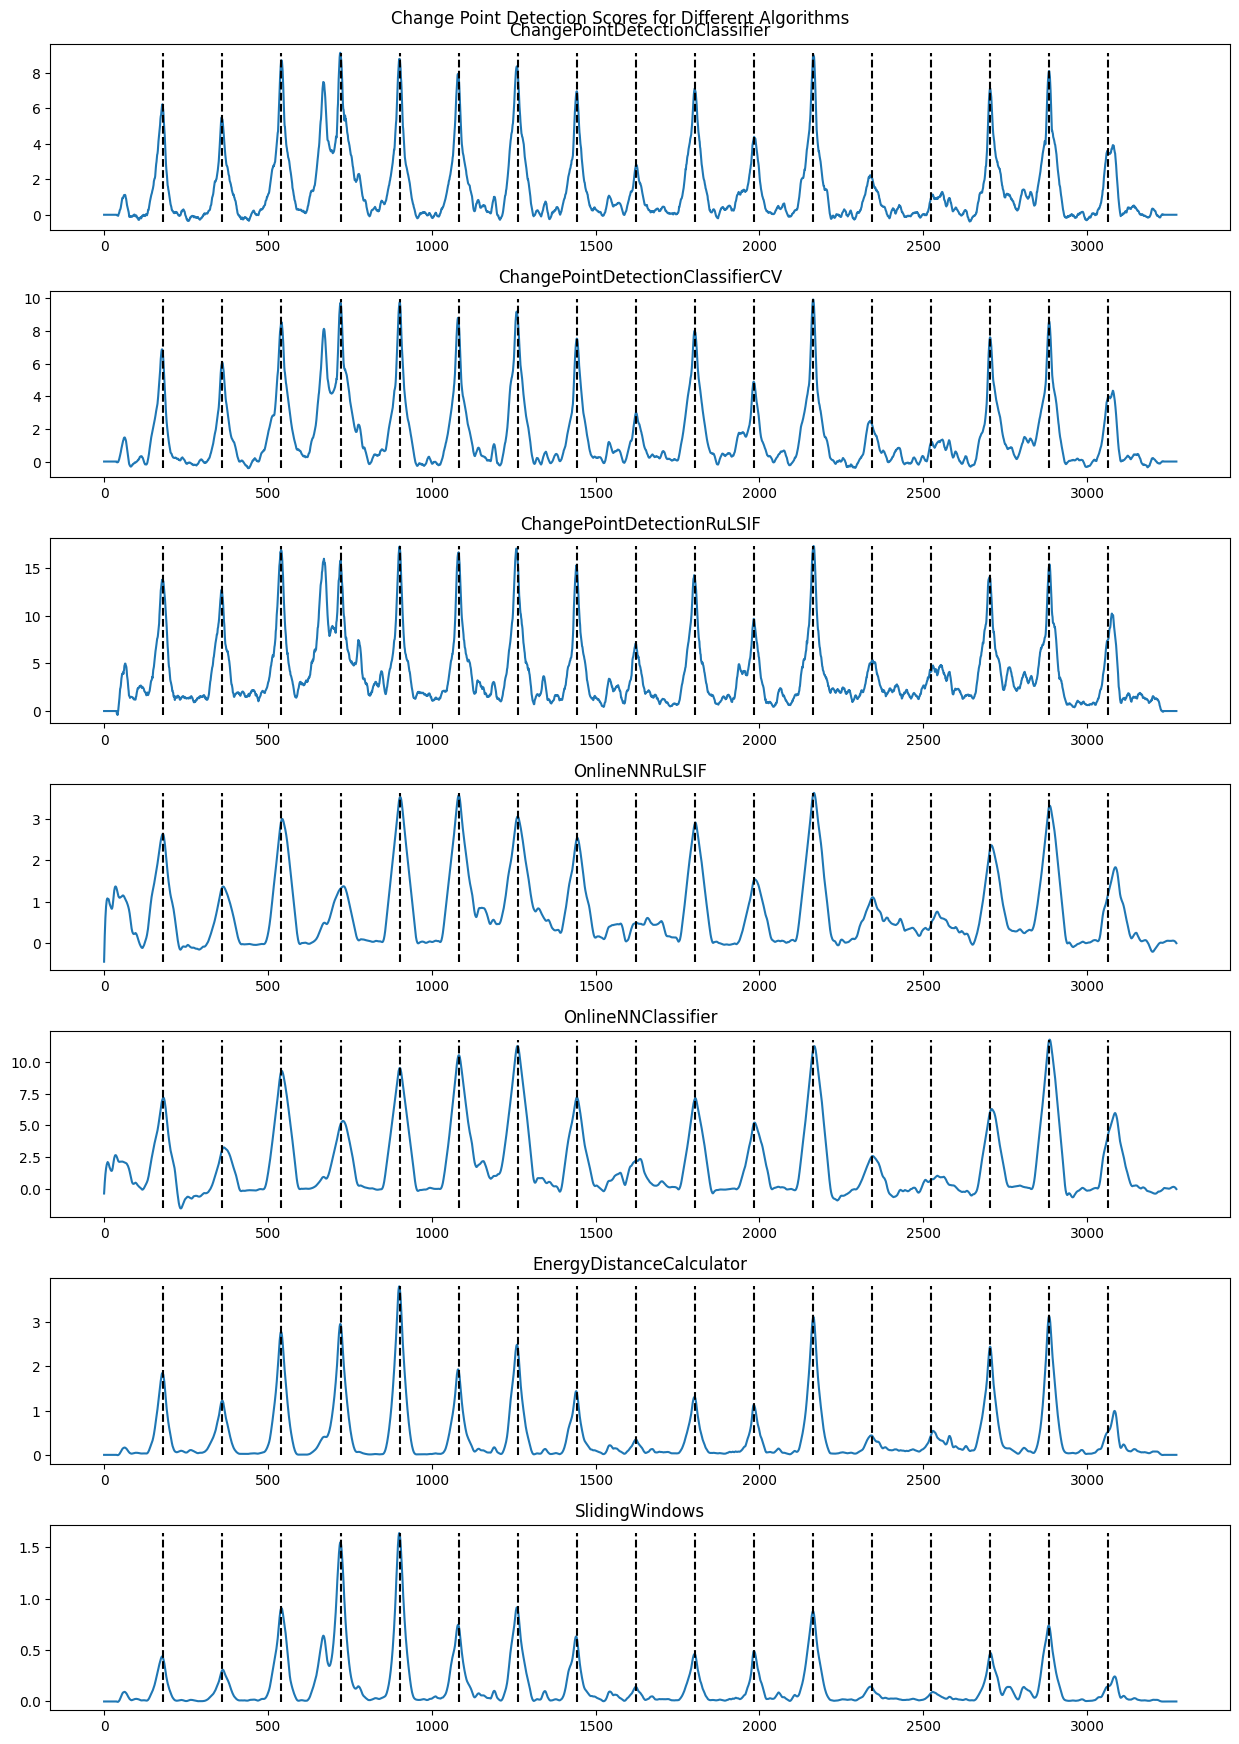

In [18]:
fig, axes = plt.subplots(len(algorithms), 1, figsize=(12.5, len(algorithms) * 2.5 + 0.25))
for i, (cpd, alg_name) in enumerate(algorithms):
    axes[i].plot(scores[i])
    axes[i].set_title(alg_name)
    axes[i].vlines(cps_true, ymin=min(scores[i]), ymax=max(scores[i]), color='black', ls='--')
plt.suptitle('Change Point Detection Scores for Different Algorithms')
plt.tight_layout()

### Ruptures

In [19]:
#!pip install -q ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.1 MB/s eta 0:00:00


We will test a [Window](https://centre-borelli.github.io/ruptures-docs/user-guide/detection/window/) method with an unknown number of change-points

In [20]:
import ruptures as rpt

algo = rpt.Window(width=2*50, jump=1, model='rbf').fit(X_ss)

In [21]:
print('Training set size:', X_ss.shape[0])
print('Ruptures scores size:', algo.score.size)

Training set size: 3274
Ruptures scores size: 3174


There are 100 (size of a window width) scores missing. There is also an offset, so we shall add some values to the begin and end of the scores' array.

Text(0.5, 1.0, 'Ruptures Windows score')

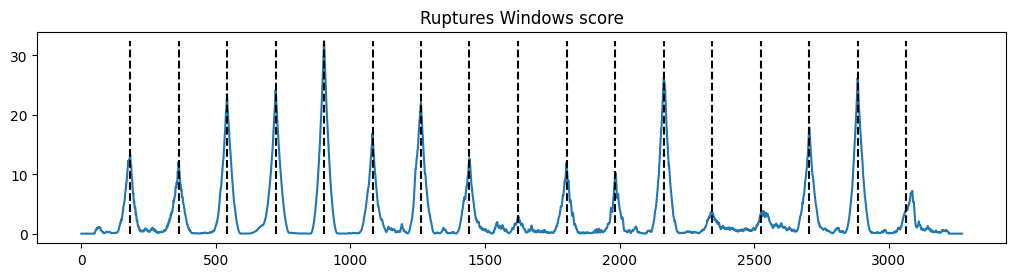

In [22]:
rpt_scores = np.concatenate([np.zeros(50), algo.score, np.zeros(50)])
plt.figure(figsize=(12.5, 2.5+0.25))
plt.plot(rpt_scores)
plt.vlines(cps_true, ymin=min(rpt_scores), ymax=max(rpt_scores), color='black', ls='--')
plt.title('Ruptures Windows score')

In [23]:
from scipy.signal import argrelmax

peaks = argrelmax(rpt_scores, order=50)[0]
peaks

array([  65,  182,  265,  361,  541,  722,  902, 1082, 1262, 1442, 1545,
       1623, 1803, 1986, 2165, 2339, 2535, 2705, 2885, 3088, 3214])

In [24]:
df.loc['Ruptures Window'] = calculate_metrics(cps_true, peaks, rpt_scores)
df

,precision,recall,AUC-PR
algorithm,,,
ChangePointDetectionClassifier,0.850000,1.0,1.000000
ChangePointDetectionClassifierCV,0.772727,1.0,0.996636
ChangePointDetectionRuLSIF,0.739130,1.0,0.932255
OnlineNNRuLSIF,0.894737,1.0,0.985207
OnlineNNClassifier,0.894737,1.0,0.989269
EnergyDistanceCalculator,0.894737,1.0,1.000000
SlidingWindows,0.894737,1.0,0.993636
Ruptures Window,0.809524,1.0,1.000000


### `klcpd`

In [25]:
#!pip install -q git+https://github.com/HolyBayes/klcpd

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from klcpd import KL_CPD

dim = 3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = KL_CPD(dim, p_wnd_dim=50, f_wnd_dim=50).to(device)
model.fit(X_ss)
preds = model.predict(X_ss)

Text(0.5, 1.0, 'KL-CPD score')

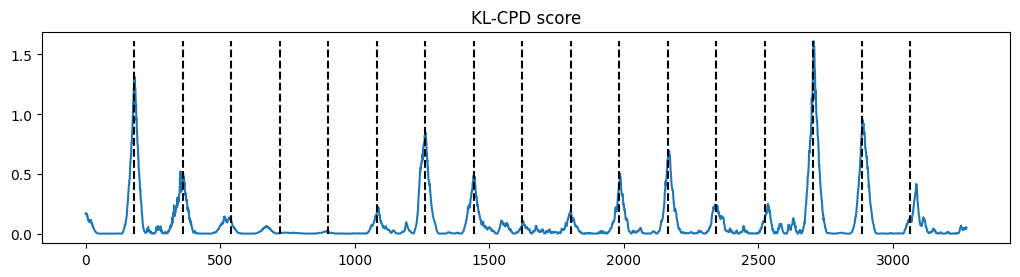

In [27]:
plt.figure(figsize=(12.5, 2.5+0.25))
plt.plot(preds)
plt.vlines(cps_true, ymin=min(preds), ymax=max(preds), color='black', ls='--')
plt.title('KL-CPD score')

In [28]:
peaks = argrelmax(preds, order=50)[0]
peaks

array([   1,  181,  352,  516,  673,  893, 1086, 1264, 1443, 1545, 1625,
       1803, 1986, 2168, 2339, 2445, 2535, 2705, 2886, 3087, 3253])

In [29]:
df.loc['KL-CPD'] = calculate_metrics(cps_true, peaks, preds)
df

,precision,recall,AUC-PR
algorithm,,,
ChangePointDetectionClassifier,0.850000,1.0,1.000000
ChangePointDetectionClassifierCV,0.772727,1.0,0.996636
ChangePointDetectionRuLSIF,0.739130,1.0,0.932255
OnlineNNRuLSIF,0.894737,1.0,0.985207
OnlineNNClassifier,0.894737,1.0,0.989269
EnergyDistanceCalculator,0.894737,1.0,1.000000
SlidingWindows,0.894737,1.0,0.993636
Ruptures Window,0.809524,1.0,1.000000
KL-CPD,0.809524,1.0,0.965243
